# Data prep for MIT-BIH

In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split



%matplotlib inline

## Variables Definitions

In [2]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

* **N (Normal):** The "N" represents a normal heartbeat or cardiac complex. It indicates that the electrical activity of the heart is within the normal range, and there are no abnormalities or irregularities in the heart rhythm.
* **L (Left bundle branch block):** An "L" complex indicates the presence of a left bundle branch block. This is an abnormality in the electrical conduction system of the heart, where the electrical signals do not travel normally through the left bundle branch. It can affect the timing and coordination of ventricular contractions.
* **R (Right bundle branch block):** An "R" complex indicates a right bundle branch block. Similar to left bundle branch block, this signifies an abnormality in the electrical conduction system involving the right bundle branch.
* **A (Atrial premature beat):** An "A" complex represents an atrial premature beat, which is an early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.
* **V (Ventricular premature beat):** A "V" complex represents a ventricular premature beat, which is an early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.


In [3]:
path = 'mitbih_database/'
window_size = 1000
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

## Prepare Input Files

In [4]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [5]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)
print(records[0])
print(annotations[0])

mitbih_database/100.csv
mitbih_database/100annotations.txt


## Data Extraction and Preprocessing

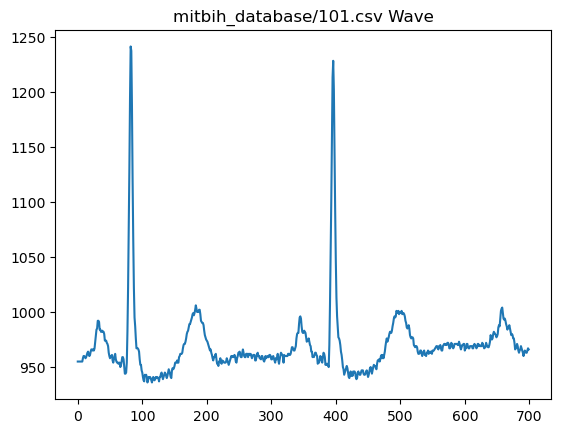

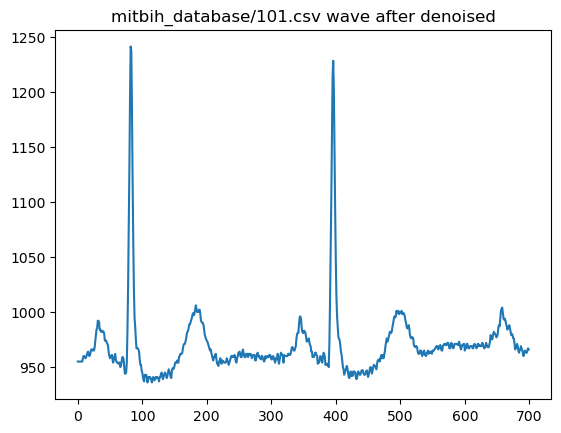

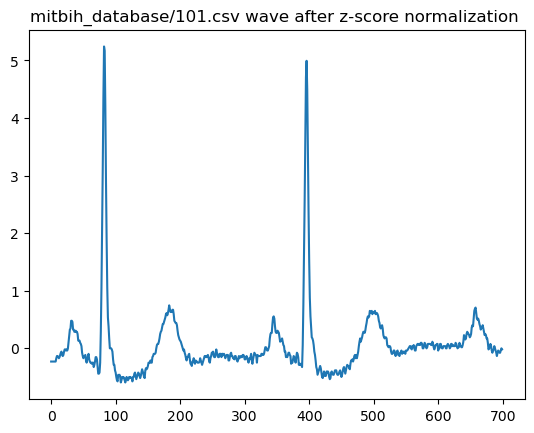

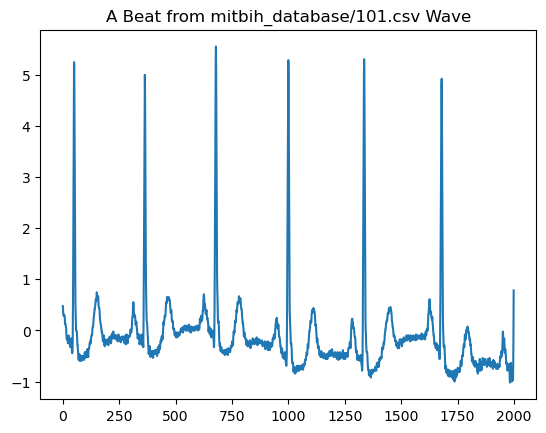

(99754, 2000) (99754,)


In [6]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [7]:
print(count_classes)

[75052, 8075, 7259, 2546, 7130]


In [8]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))


(99754, 2001)


2000
0.0    74815
1.0     8053
2.0     7235
4.0     7114
3.0     2537
Name: count, dtype: int64


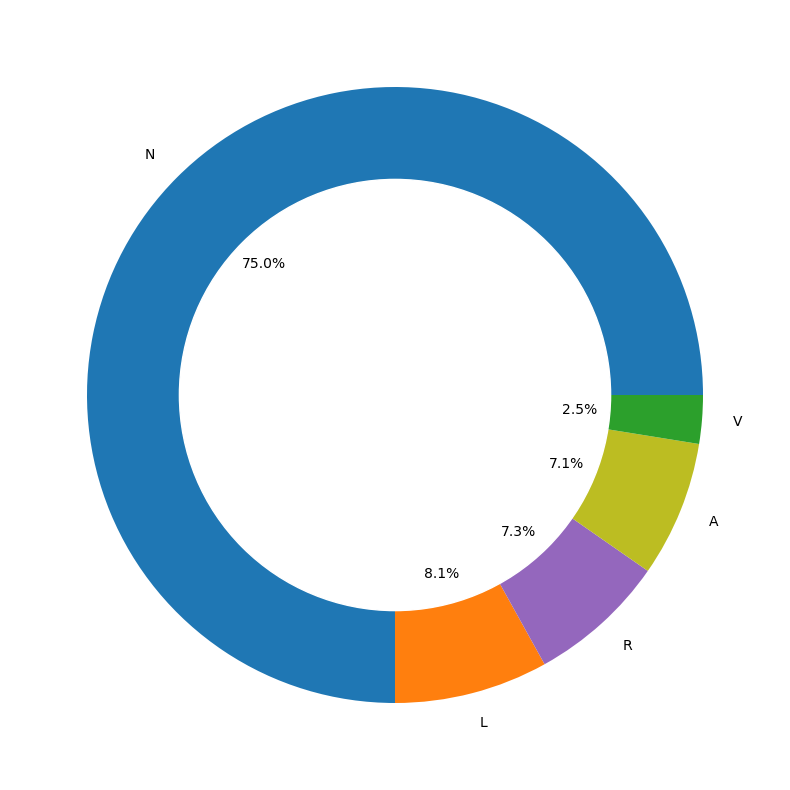

In [9]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [10]:
X_train_df.to_json('mydata-mitbih.json')

In [19]:
X_train_df_small = X_train_df.sample(frac=1).head(5000)

2000
0.0    3764
2.0     373
4.0     371
1.0     365
3.0     127
Name: count, dtype: int64


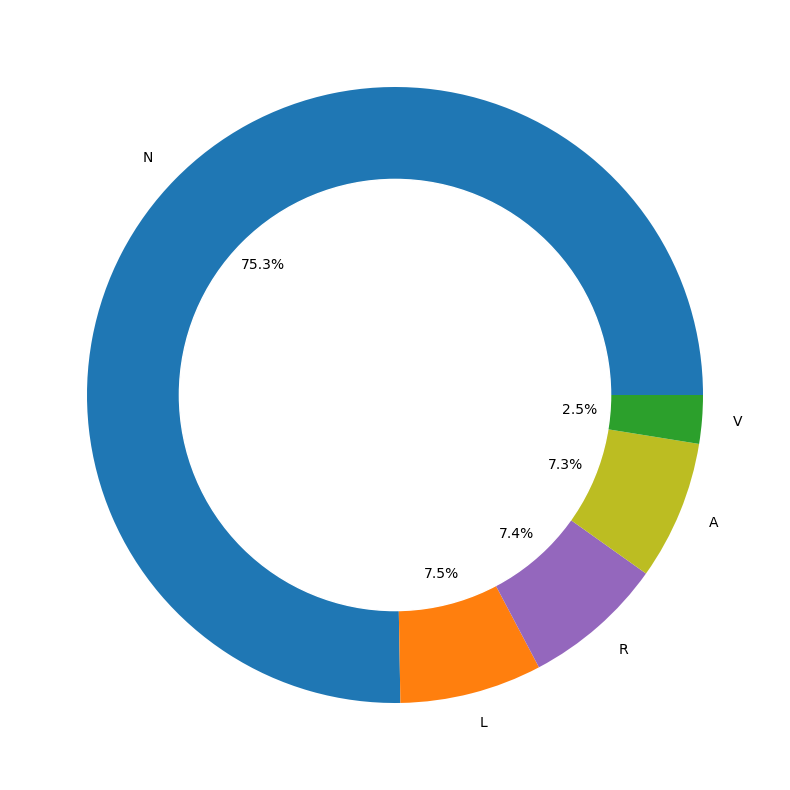

In [20]:
per_class = X_train_df_small[X_train_df_small.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [21]:
X_train_df_small.to_json('mydata-mitbih-small.json')